<a href="https://colab.research.google.com/github/mbsuraj/Clustering_Neighborhoods_Using_FoursquareAPI/blob/master/Neighborhood_of_Phoenix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
!pip install pgeocode
import pgeocode
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
/gdrive


In [3]:
#obtained zip codes of phoenix from the internet
file  = r'/gdrive/My Drive/IBMCertification/Capstone/Phoenix_Zip.csv'
phoenix_zip = pd.read_csv(file)
phoenix_zip

,Zip Code
0,85001
1,85002
2,85003
3,85004
4,85005
...,...
106,85266
107,85267
108,85268
109,85271


In [0]:
#using pgeocode to obtain the lat and long values
nomi = pgeocode.Nominatim('us')

def add_lat_long(x):
  lat = []
  long = []
  for i in x['Zip Code'].values:
    details = nomi.query_postal_code("{}".format(i))
    lat.append(details['latitude'])
    long.append(details['longitude'])
  lat = np.round(lat, 2)
  long = np.round(long, 2)
  return lat, long

In [5]:
lat, long = add_lat_long(phoenix_zip)
phoenix_zip['Latitude'] = lat
phoenix_zip['Longitude'] = long
phoenix_zip

,Zip Code,Latitude,Longitude
0,85001,33.45,-112.07
1,85002,33.45,-112.07
2,85003,33.45,-112.08
3,85004,33.46,-112.07
4,85005,33.45,-112.07
...,...,...,...
106,85266,33.77,-111.92
107,85267,33.51,-111.90
108,85268,33.61,-111.72
109,85271,33.51,-111.90


In [6]:
phoenix_zip.dropna(inplace = True)
phoenix_zip.drop_duplicates(subset = ['Zip Code'], inplace= True, ignore_index= True)
phoenix_zip.drop_duplicates(subset = ['Latitude', 'Longitude'], inplace= True, ignore_index= True)
phoenix_zip

,Zip Code,Latitude,Longitude
0,85001,33.45,-112.07
1,85003,33.45,-112.08
2,85004,33.46,-112.07
3,85006,33.47,-112.05
4,85007,33.45,-112.09
...,...,...,...
65,85260,33.60,-111.89
66,85261,33.51,-111.90
67,85262,33.78,-111.78
68,85266,33.77,-111.92


In [7]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


In [8]:
address = 'Phoenix'

geolocator = Nominatim(user_agent="phoenix_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Phoenix are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Phoenix are 33.4484367, -112.0741417.


In [9]:
#now we can start exploring using Foursquare API

# create map of Phoenix using latitude and longitude values
map_phoenix = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, zip_code in zip(phoenix_zip['Latitude'], phoenix_zip['Longitude'], phoenix_zip['Zip Code']):
    label = '{}, Phoenix'.format(zip_code)
    label = folium.Popup(label,  parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_phoenix)  
    
map_phoenix

**using foursquare api to explore the neighborhoods**

In [10]:
CLIENT_ID = 'X3JALAR10YCAYAFQA5AIL3P3BOQKIIIOMG33BIGEXEC35YMI'
CLIENT_SECRET = 'XZAR3MOGJNMDPRGWXYXT52XS3FWJZVQN0HRBZVWOUBV02TUR'
VERSION = '20180604'
print('Your credentials: ')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET: ' + CLIENT_SECRET)

Your credentials: 
CLIENT_ID: X3JALAR10YCAYAFQA5AIL3P3BOQKIIIOMG33BIGEXEC35YMI
CLIENT_SECRET: XZAR3MOGJNMDPRGWXYXT52XS3FWJZVQN0HRBZVWOUBV02TUR


In [0]:

radius = 500
LIMIT = 1000

venues = []

for x, y, zip_code in zip(phoenix_zip['Latitude'], phoenix_zip['Longitude'], phoenix_zip['Zip Code']):
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        x,
        y,
        radius, 
        LIMIT)
    
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            zip_code,
            x, 
            y, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))

In [12]:
# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['ZipCode', 'ZipLatitude', 'ZipLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(730, 7)


,ZipCode,ZipLatitude,ZipLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,85001,33.45,-112.07,Herberger Theater Center,33.450578,-112.070476,Theater
1,85001,33.45,-112.07,Symphony Hall,33.448410,-112.070701,Opera House
2,85001,33.45,-112.07,Sheraton Grand Phoenix,33.452266,-112.070349,Hotel
3,85001,33.45,-112.07,The Kettle Black,33.448468,-112.072451,Pub
4,85001,33.45,-112.07,Downtown Salon Phoenix,33.450323,-112.072548,Salon / Barbershop


**looking at the number of venues per zip code**

In [13]:
venues_df[['ZipCode', 'VenueName']].groupby('ZipCode').apply(lambda x: x['VenueName'].count())

ZipCode
85001    100
85003     11
85004     53
85006     16
85007      6
        ... 
85282      4
85284      3
85285     24
85286      5
85287      9
Length: 63, dtype: int64

**Looking at the unique venue categories in the city**

In [14]:
venues_df['VenueCategory'].unique()

array(['Theater', 'Opera House', 'Hotel', 'Pub', 'Salon / Barbershop',
       'Hotel Bar', 'Park', 'Music Venue', 'Juice Bar', 'Lounge',
       'History Museum', 'Pizza Place', 'American Restaurant',
       'Coffee Shop', 'Bar', 'Beer Bar', 'Science Museum',
       'Sandwich Place', 'Basketball Stadium', 'Grocery Store',
       'Cocktail Bar', 'General Entertainment', 'Shopping Mall',
       'Japanese Restaurant', 'Thai Restaurant', 'Fast Food Restaurant',
       'Nightclub', 'Sushi Restaurant', 'Mexican Restaurant',
       'Breakfast Spot', 'Gym', 'Fried Chicken Joint',
       'New American Restaurant', 'Theme Restaurant', 'Rock Club',
       'Restaurant', 'Wine Bar', 'Movie Theater', 'Art Gallery',
       'Irish Pub', 'Sports Bar', 'Accessories Store',
       'Gym / Fitness Center', 'Vegetarian / Vegan Restaurant',
       'Speakeasy', 'Noodle House', 'Basketball Court', 'Bank',
       'Clothing Store', "Men's Store", 'Ice Cream Shop',
       'Shipping Store', 'College Cafeteria', 'It

**Analyzing Each Area**

In [15]:
# one hot encoding
phoenix_onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
phoenix_onehot['ZipCode'] = venues_df['ZipCode']  

# move postal, borough and neighborhood column to the first column
fixed_columns = list([phoenix_onehot.columns[-1]]) + list(phoenix_onehot.columns[:-1])
phoenix_onehot = phoenix_onehot[fixed_columns]

print(phoenix_onehot.shape)
phoenix_onehot.head()

(730, 202)


,ZipCode,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Big Box Store,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Café,...,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tattoo Parlor,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,85001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,85001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,85001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,85001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,85001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


**Now, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [16]:
phoenix_grouped = phoenix_onehot.groupby(["ZipCode"]).mean().reset_index()

print(phoenix_grouped.shape)
phoenix_grouped.head()

(63, 202)


,ZipCode,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Big Box Store,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,Café,...,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tattoo Parlor,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,85001,0.01,0.0,0.0,0.0,0.0,0.070000,0.0,0.000000,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.01,0.020000,0.0,0.0,0.01,0.03,0.010000,0.0,0.000000,0.0,0.000000,0.020000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,...,0.0,0.010000,0.0,0.03,0.030000,0.0,0.01,0.0000,0.01,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.030000,0.000000,0.0,0.02,0.010000,0.0,0.01,0.000000,0.0,0.01,0.010000,0.0,0.0,0.0,0.01,0.0,0.0,0.0
1,85003,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.00,0.000000,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.090909,0.090909,0.000000,0.0,0.0,0.0,0.0,0.000,...,0.0,0.090909,0.0,0.00,0.000000,0.0,0.00,0.0000,0.00,0.0,0.00,0.0,0.0,0.0,0.090909,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.090909,0.000000,0.0,0.00,0.090909,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
2,85004,0.00,0.0,0.0,0.0,0.0,0.056604,0.0,0.018868,0.132075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018868,0.0,0.0000,0.00,0.056604,0.0,0.0,0.00,0.00,0.018868,0.0,0.018868,0.0,0.018868,0.018868,0.018868,0.000000,0.018868,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000000,0.0,0.00,0.037736,0.0,0.00,0.0000,0.00,0.0,0.00,0.0,0.0,0.0,0.018868,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.018868,0.037736,0.0,0.00,0.018868,0.0,0.00,0.018868,0.0,0.00,0.018868,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,85006,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0625,0.00,0.062500,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.125,...,0.0,0.000000,0.0,0.00,0.000000,0.0,0.00,0.0625,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.125000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0
4,85007,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.00,0.000000,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000,...,0.0,0.000000,0.0,0.00,0.166667,0.0,0.00,0.0000,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0


**Now let's create the new dataframe and display the top 10 venues for each ZipCode.**

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['ZipCode']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['ZipCode'] = phoenix_grouped['ZipCode']

for ind in np.arange(phoenix_grouped.shape[0]):
    row_categories = phoenix_grouped.iloc[ind, :].iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    neighborhoods_venues_sorted.iloc[ind, 1:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(neighborhoods_venues_sorted.shape)
neighborhoods_venues_sorted

(63, 11)


,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,85001,Coffee Shop,American Restaurant,Pizza Place,Hotel,Lounge,Mexican Restaurant,Salon / Barbershop,Basketball Stadium,Sandwich Place,Sushi Restaurant
1,85003,Music Venue,Coffee Shop,Southern / Soul Food Restaurant,Brewery,Building,Rock Club,Sushi Restaurant,Theater,Mattress Store,History Museum
2,85004,Art Gallery,Coffee Shop,American Restaurant,Dessert Shop,Bar,Cocktail Bar,Sandwich Place,Taco Place,Performing Arts Venue,Bike Shop
3,85006,Coffee Shop,Taco Place,Café,Clothing Store,Art Gallery,Liquor Store,Bakery,Bar,Restaurant,Seafood Restaurant
4,85007,Plaza,Food Truck,Breakfast Spot,Sandwich Place,Discount Store,Memorial Site,Yoga Studio,Dry Cleaner,Fast Food Restaurant,Farmers Market
...,...,...,...,...,...,...,...,...,...,...,...
58,85282,Soccer Field,Plaza,Park,Pub,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop
59,85284,Soccer Field,Spa,Park,Doctor's Office,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop
60,85285,Pool,Hookah Bar,Sushi Restaurant,Thai Restaurant,Shipping Store,Donut Shop,Residential Building (Apartment / Condo),Discount Store,Mobile Phone Shop,Japanese Restaurant
61,85286,Park,Playground,Plaza,Home Service,Afghan Restaurant,Food,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm


**Now clustering neighborhood using kmeans**

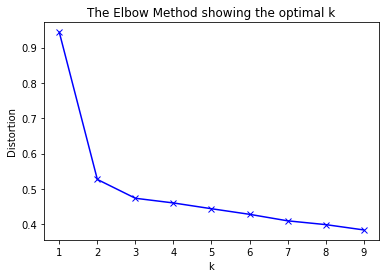

In [23]:
#first deciding number of clusters to be used
#For creating a reasonable cluster location data is also take into considerations. I am lat long data also into the phoenix_grouped data.

df = pd.merge(phoenix_zip,  phoenix_grouped, how = 'right', left_on= 'Zip Code', right_on= 'ZipCode')

K = range(1, 10)
distortions = []
X = df.drop(columns = ['ZipCode', 'Zip Code']).copy()
for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init= 500, max_iter = 1000).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()


In [24]:
X.head()

,Latitude,Longitude,Accessories Store,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Big Box Store,Bike Shop,Bookstore,Boutique,Breakfast Spot,Brewery,Building,Burger Joint,Bus Station,Bus Stop,Business Center,Business Service,...,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shipping Store,Shop & Service,Shopping Mall,Shopping Plaza,Smoke Shop,Soccer Field,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Speakeasy,Sports Bar,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tattoo Parlor,Thai Restaurant,Theater,Theme Park,Theme Restaurant,Thrift / Vintage Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Cluster Labels
0,33.45,-112.07,0.01,0.0,0.0,0.0,0.0,0.070000,0.0,0.000000,0.010000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.01,0.020000,0.0,0.0,0.01,0.03,0.010000,0.0,0.000000,0.0,0.000000,0.020000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.010000,0.0,0.03,0.030000,0.0,0.01,0.0000,0.01,0.0,0.02,0.0,0.0,0.0,0.000000,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.030000,0.000000,0.0,0.02,0.010000,0.0,0.01,0.000000,0.0,0.01,0.010000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0
1,33.45,-112.08,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.00,0.000000,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.090909,0.090909,0.000000,0.0,0.0,0.0,0.0,...,0.090909,0.0,0.00,0.000000,0.0,0.00,0.0000,0.00,0.0,0.00,0.0,0.0,0.0,0.090909,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.090909,0.000000,0.0,0.00,0.090909,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0
2,33.46,-112.07,0.00,0.0,0.0,0.0,0.0,0.056604,0.0,0.018868,0.132075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018868,0.0,0.0000,0.00,0.056604,0.0,0.0,0.00,0.00,0.018868,0.0,0.018868,0.0,0.018868,0.018868,0.018868,0.000000,0.018868,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00,0.037736,0.0,0.00,0.0000,0.00,0.0,0.00,0.0,0.0,0.0,0.018868,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.018868,0.037736,0.0,0.00,0.018868,0.0,0.00,0.018868,0.0,0.00,0.018868,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0
3,33.47,-112.05,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0625,0.00,0.062500,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00,0.000000,0.0,0.00,0.0625,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.125000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0
4,33.45,-112.09,0.00,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0000,0.00,0.000000,0.0,0.0,0.00,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.166667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.00,0.166667,0.0,0.00,0.0000,0.00,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.000000,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0


In [31]:
#above curve is somewhat elbowing at k = 4. so we choose 4 clusters for phoenix city

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, n_init = 500, max_iter = 1000, random_state=0).fit(X)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [32]:
# add clustering labels
phoenix_grouped["Cluster Labels"] = kmeans.labels_
#merge phoenix with phoenix to add latitude/longitude for each neighborhood 

phoenix_merged = pd.merge(phoenix_zip,  phoenix_grouped[["Cluster Labels", 'ZipCode']], how = 'inner', left_on= 'Zip Code', right_on= 'ZipCode')
phoenix_merged = pd.merge(neighborhoods_venues_sorted, phoenix_merged[["Cluster Labels", 'ZipCode', 'Latitude', 'Longitude']], how = 'inner', on = 'ZipCode')

print(phoenix_merged.shape)
phoenix_merged # check the last columns!

(63, 14)


,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,85001,Coffee Shop,American Restaurant,Pizza Place,Hotel,Lounge,Mexican Restaurant,Salon / Barbershop,Basketball Stadium,Sandwich Place,Sushi Restaurant,3,33.45,-112.07
1,85003,Music Venue,Coffee Shop,Southern / Soul Food Restaurant,Brewery,Building,Rock Club,Sushi Restaurant,Theater,Mattress Store,History Museum,3,33.45,-112.08
2,85004,Art Gallery,Coffee Shop,American Restaurant,Dessert Shop,Bar,Cocktail Bar,Sandwich Place,Taco Place,Performing Arts Venue,Bike Shop,3,33.46,-112.07
3,85006,Coffee Shop,Taco Place,Café,Clothing Store,Art Gallery,Liquor Store,Bakery,Bar,Restaurant,Seafood Restaurant,3,33.47,-112.05
4,85007,Plaza,Food Truck,Breakfast Spot,Sandwich Place,Discount Store,Memorial Site,Yoga Studio,Dry Cleaner,Fast Food Restaurant,Farmers Market,3,33.45,-112.09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,85282,Soccer Field,Plaza,Park,Pub,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,1,33.39,-111.92
59,85284,Soccer Field,Spa,Park,Doctor's Office,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,1,33.34,-111.92
60,85285,Pool,Hookah Bar,Sushi Restaurant,Thai Restaurant,Shipping Store,Donut Shop,Residential Building (Apartment / Condo),Discount Store,Mobile Phone Shop,Japanese Restaurant,3,33.41,-111.91
61,85286,Park,Playground,Plaza,Home Service,Afghan Restaurant,Food,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,3,33.27,-111.83


In [33]:
# sort the results by Cluster Labels
print(phoenix_merged.shape)
phoenix_merged.sort_values(["Cluster Labels"], inplace=True, ignore_index= True)
phoenix_merged

(63, 14)


,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,85260,Farm,Intersection,Rest Area,Yoga Studio,Dive Bar,Fishing Spot,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,0,33.60,-111.89
1,85051,Home Service,Concert Hall,Seafood Restaurant,Moving Target,Doctor's Office,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,0,33.56,-112.13
2,85021,Park,Playground,American Restaurant,Dive Bar,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,1,33.56,-112.09
3,85284,Soccer Field,Spa,Park,Doctor's Office,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,1,33.34,-111.92
4,85282,Soccer Field,Plaza,Park,Pub,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,1,33.39,-111.92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,85042,Fast Food Restaurant,Pizza Place,Grocery Store,Sandwich Place,Ice Cream Shop,Burger Joint,Bank,Mobile Phone Shop,Coffee Shop,Hawaiian Restaurant,3,33.38,-112.03
59,85043,Fast Food Restaurant,Convenience Store,Discount Store,Yoga Studio,Donut Shop,Flower Shop,Fishing Spot,Farmers Market,Farm,Falafel Restaurant,3,33.45,-112.20
60,85044,Auto Garage,Spa,Gym / Fitness Center,Golf Course,Yoga Studio,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,3,33.33,-111.99
61,85019,Home Service,African Restaurant,Rental Service,Pharmacy,Bakery,Pizza Place,Health & Beauty Service,Disc Golf,Farm,Falafel Restaurant,3,33.51,-112.14


**A Look at the Clusters**

In [34]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for x, y, zip_code, cluster in zip(phoenix_merged['Latitude'], phoenix_merged['Longitude'], phoenix_merged['ZipCode'], phoenix_merged['Cluster Labels']):
    label = folium.Popup('{} - Cluster {}'.format(zip_code, cluster), parse_html=True)
    folium.CircleMarker(
        [x, y],
        radius=5,
        popup=label,
        color=['black'],
        fill=True, 
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Let's have a look at the clusters**

In [35]:
#Cluster 0
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 0]

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
0,85260,Farm,Intersection,Rest Area,Yoga Studio,Dive Bar,Fishing Spot,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Fabric Shop,0,33.60,-111.89
1,85051,Home Service,Concert Hall,Seafood Restaurant,Moving Target,Doctor's Office,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,0,33.56,-112.13


In [36]:
#Cluster 1
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 1, :]

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
2,85021,Park,Playground,American Restaurant,Dive Bar,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,1,33.56,-112.09
3,85284,Soccer Field,Spa,Park,Doctor's Office,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,1,33.34,-111.92
4,85282,Soccer Field,Plaza,Park,Pub,Dive Bar,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,1,33.39,-111.92
5,85028,Road,Park,Discount Store,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,Event Service,Dry Cleaner,1,33.59,-112.01
6,85251,Mexican Restaurant,Park,Art Museum,Baseball Stadium,Souvenir Shop,Sports Bar,Dive Bar,Public Art,Theater,New American Restaurant,1,33.49,-111.92
7,85266,Business Service,Massage Studio,Coffee Shop,Italian Restaurant,Grocery Store,Yoga Studio,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,1,33.77,-111.92
8,85259,Pizza Place,Coffee Shop,Pharmacy,Italian Restaurant,Playground,Discount Store,Restaurant,Mobile Phone Shop,Middle Eastern Restaurant,Donut Shop,1,33.59,-111.84
9,85252,Steakhouse,Yoga Studio,Food Service,Flower Shop,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,1,33.50,-111.87
10,85254,Intersection,Business Center,Yoga Studio,Donut Shop,Flower Shop,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,1,33.62,-111.96


In [37]:
#Cluster 2
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 2, :]

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
11,85085,Scenic Lookout,Trail,Mountain,Auto Workshop,Yoga Studio,Donut Shop,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,2,33.75,-112.09
12,85023,Fast Food Restaurant,Trail,Yoga Studio,Doctor's Office,Flower Shop,Fishing Spot,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,2,33.63,-112.11
13,85022,Trail,Women's Store,Garden Center,Doctor's Office,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,2,33.63,-112.05
14,85048,Trail,Yoga Studio,Doctor's Office,Flower Shop,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,Fabric Shop,2,33.32,-112.07


In [38]:
#Cluster 3
phoenix_merged.loc[phoenix_merged['Cluster Labels'] == 3]

,ZipCode,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels,Latitude,Longitude
15,85255,Pharmacy,Steakhouse,Pizza Place,Indian Restaurant,Salon / Barbershop,Shipping Store,Bank,Miscellaneous Shop,Supermarket,Gas Station,3,33.70,-111.89
16,85053,Hookah Bar,Greek Restaurant,Park,Cosmetics Shop,Deli / Bodega,Disc Golf,Discount Store,Mexican Restaurant,Pizza Place,Bakery,3,33.63,-112.13
17,85054,Hotel,Construction & Landscaping,Event Service,Doctor's Office,Flower Shop,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,3,33.67,-111.95
18,85285,Pool,Hookah Bar,Sushi Restaurant,Thai Restaurant,Shipping Store,Donut Shop,Residential Building (Apartment / Condo),Discount Store,Mobile Phone Shop,Japanese Restaurant,3,33.41,-111.91
19,85224,Fast Food Restaurant,Greek Restaurant,Herbs & Spices Store,Big Box Store,Vietnamese Restaurant,Video Store,Pizza Place,Convenience Store,Indian Restaurant,Coffee Shop,3,33.33,-111.86
20,85225,Business Service,Baseball Field,Video Store,Gas Station,Dry Cleaner,Yoga Studio,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,3,33.31,-111.82
21,85226,Playground,Gym / Fitness Center,Food Truck,Theme Park,Athletics & Sports,Fishing Spot,Park,Doctor's Office,Fast Food Restaurant,Comic Shop,3,33.31,-111.92
22,85244,Health & Beauty Service,Spa,Bar,Grocery Store,Insurance Office,Frozen Yogurt Shop,Laundry Service,Mexican Restaurant,Pet Store,Coffee Shop,3,33.32,-111.89
23,85246,Mexican Restaurant,Pizza Place,Taco Place,Performing Arts Venue,Pool,Liquor Store,Sandwich Place,Bar,Bakery,Korean Restaurant,3,33.31,-111.84
24,85248,College Classroom,Doctor's Office,Home Service,Park,Gym,Fishing Spot,Fast Food Restaurant,Farmers Market,Farm,Falafel Restaurant,3,33.25,-111.86


**Based on above results we can conclude the following:**
1. **Cluster 0:** Places to go for peaceful activities like Yoga, Rest areas etc.
2. **Cluster 1:** Places for any outdoor activity like soccer field, park, fishing spot etc.
3.**Cluster 2:** Fast food and restaurants
4. **Cluster 3:** Wide array of utilities and helthcare venues are present here.